In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



In [2]:

# CIFAR-10 dataset with normalization and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

Files already downloaded and verified


In [3]:

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 上采样至 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 上采样至 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 上采样至 32x32
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输出图像的尺寸是 3x32x32
        )

    def forward(self, z):
        z = z.view(-1, 100, 1, 1)
        return self.model(z)
# Critic (Discriminator)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            # 输入图像尺寸是 3x32x32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 4x4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            # 输出一个单一的数值
        )
    def forward(self, x):
        return self.model(x)





In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
NetG = Generator().to(device)
NetC = Critic().to(device)

In [5]:

# Wasserstein Loss Function
def wasserstein_loss(y_real, y_fake):
    return torch.mean(y_fake) - torch.mean(y_real)

# Gradient Penalty function
def gradient_penalty(critic, real_data, fake_data):
    # Ensure tensors are on the same device
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(real_data.device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data

    interpolates.requires_grad_(True)
    critic_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradient_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)

    return penalty

In [6]:
import torch
import torch.optim as optim

# Function to compute the gradient norm
def gradient_norm(model):
    norms = []
    for param in model.parameters():
        if param.grad is not None:
            norms.append(param.grad.norm().item())
    return norms

# Train the WGAN, capturing losses, gradient norms, and printing updates
def train_wgan(generator, critic, dataloader, num_epochs, device):
    optimizer_G = optim.RMSprop(generator.parameters(), lr=5e-5)
    optimizer_D = optim.RMSprop(critic.parameters(), lr=5e-5)

    # Lists to store generator and critic losses, and gradient norms
    generator_losses = []
    critic_losses = []
    gradient_norms_generator = []
    gradient_norms_critic = []

    for epoch in range(num_epochs):
        epoch_generator_loss = 0
        epoch_critic_loss = 0
        generator_norms = []
        critic_norms = []

        iterations = 0
        for i, (data, _) in enumerate(dataloader):
            optimizer_D.zero_grad()
            real_data = data.to(device)
            z = torch.randn(real_data.size(0), 100).to(device)
            fake_data = generator(z)

            # Critic update
            critic_loss = wasserstein_loss(critic(real_data), critic(fake_data)) + gradient_penalty(critic, real_data, fake_data)
            critic_loss.backward()
            # critic_norms.append(gradient_norm(critic))  # Store gradient norms   ###
            optimizer_D.step()

            epoch_critic_loss += critic_loss.item()
            iterations += 1

            # Generator update every 5 iterations
            if i % 1 == 0:
                optimizer_G.zero_grad()
                # z = torch.randn(real_data.size(0), 100).to(device)  ###
                fake_data = generator(z)
                generator_loss = -torch.mean(critic(fake_data))
                generator_loss.backward()
                # generator_norms.append(gradient_norm(generator))  # Store gradient norms  ###
                optimizer_G.step()

                epoch_generator_loss += generator_loss.item()

        # Store the average losses and gradient norms
        generator_losses.append(epoch_generator_loss / (iterations / 5))
        critic_losses.append(epoch_critic_loss / iterations)
        gradient_norms_generator.append(generator_norms)
        gradient_norms_critic.append(critic_norms)   ###

        # Print epoch progress
        print(f'Epoch {epoch+1}/{num_epochs}, Generator Loss: {generator_losses[-1]:.4f}, Critic Loss: {critic_losses[-1]:.4f}')

    return generator_losses, critic_losses, gradient_norms_critic, gradient_norms_generator


In [7]:
generator_losses, critic_losses, gradient_norms_critic, gradient_norms_generator = train_wgan(NetG, NetC, trainloader, num_epochs=10,device = device)

Epoch 1/10, Generator Loss: 38.1202, Critic Loss: -3.0958
Epoch 2/10, Generator Loss: 50.9144, Critic Loss: -1.6543
Epoch 3/10, Generator Loss: 68.3295, Critic Loss: -1.9502
Epoch 4/10, Generator Loss: 71.4447, Critic Loss: -1.5505
Epoch 5/10, Generator Loss: 76.3579, Critic Loss: -1.2717
Epoch 6/10, Generator Loss: 79.2527, Critic Loss: -1.0974
Epoch 7/10, Generator Loss: 82.5655, Critic Loss: -1.0361
Epoch 8/10, Generator Loss: 85.8174, Critic Loss: -1.0491
Epoch 9/10, Generator Loss: 89.5277, Critic Loss: -1.0754
Epoch 10/10, Generator Loss: 91.6679, Critic Loss: -1.0424


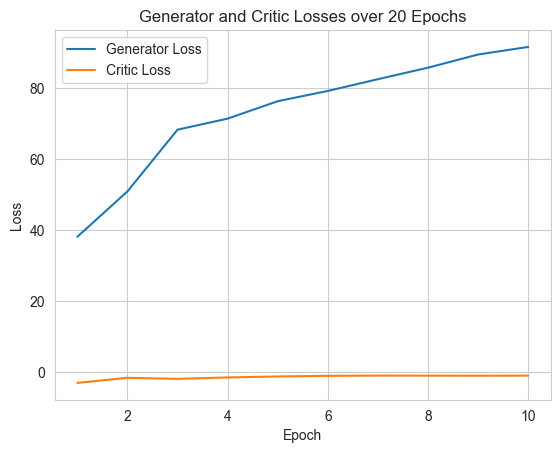

In [8]:
import matplotlib.pyplot as plt
epochs = list(range(1, 11))

plt.plot(epochs, generator_losses, label='Generator Loss')
plt.plot(epochs, critic_losses, label='Critic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Critic Losses over 20 Epochs')
plt.legend()
plt.show()

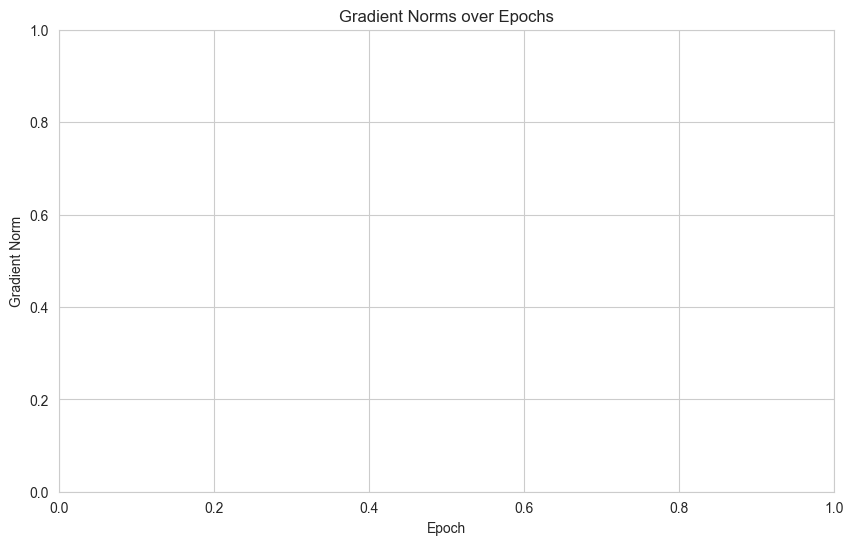

[[], [], [], [], [], [], [], [], [], []]

In [14]:
# Plotting
plt.figure(figsize=(10, 6))
for i in range(len(gradient_norms_generator[0])):
    norms = [gradient_norms_generator[j][i] for j in range(len(gradient_norms_generator))]
    plt.plot(epochs, norms, label=f'Parameter {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Epochs')
plt.grid(True)
plt.show()


gradient_norms_generator

In [10]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Function to generate and display images
def generate_images(generator, num_images=24, noise_dim=100, grid_size=(8, 8)):
    # Create random noise for image generation
    noise = torch.randn(num_images, noise_dim).to(generator.model[0].weight.device)

    # Generate images from the noise
    with torch.no_grad():  # No gradients needed during inference
        generated_images = generator(noise)

    # Create a grid of images for visualization
    image_grid = vutils.make_grid(generated_images, nrow=grid_size[0], padding=2, normalize=True)
    image_grid = image_grid.cpu()

    # Display the image grid
    plt.imshow(image_grid.permute(1, 2, 0))  # Convert to HxWxC format
    plt.axis('off')  # Hide axes
    plt.show()  # Display the generated images
    return generated_images


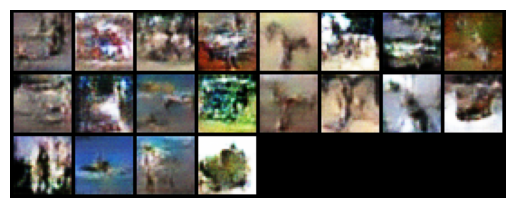

In [11]:
fake_images = generate_images(NetG, 20)

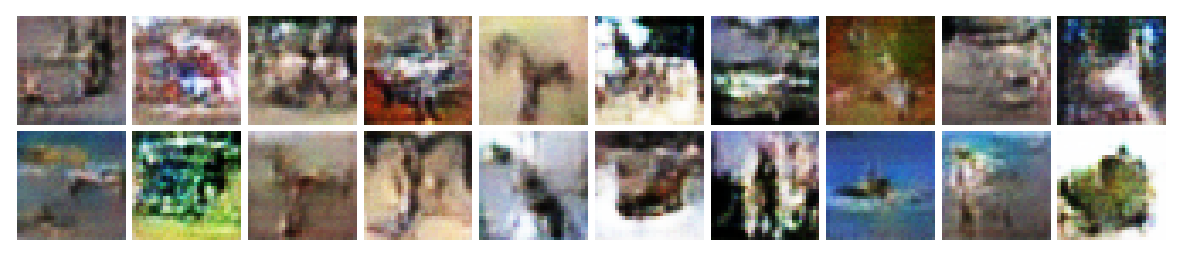

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
# 假定 fake_images, n_classes, n_examples 已经定义
def show_images(images, num_images, nrow=10, names=None, name_scale=1):
    plt.figure(figsize=(15 / 10 * nrow, 15))
    images = make_grid(images.cpu()[:num_images], nrow=nrow, padding=2, pad_value=1)
    images =  np.clip(images, 0, 1)
    npimg = images.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    single_img_height = npimg.shape[1] // (num_images // nrow) * name_scale
    if names is not None:
        for i, name in enumerate(names):
            if i >= num_images:
                break  # Break if there are more names than images
            row = i // nrow - 1
            col = i % nrow
            plt.text(col * single_img_height + single_img_height / 2, (row + 1) * single_img_height - single_img_height * 0.14,
                     name, ha='center', va='top', fontsize=12, color='black',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', boxstyle='round,pad=0.1'))
    plt.show()
show_images(fake_images/ 2 + 0.5, 20)